In [ ]:
pip install pandas

In [ ]:
pip install tqdm

In [ ]:
pip install matplotlib

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("insider_trades_with_returns.csv")
df = df.dropna(subset=["fwd_1d", "fwd_5d", "fwd_15d"])

# Clean purchase_price & Value to numeric
df["purchase_price"] = df["purchase_price"].replace('[\$,]', '', regex=True).astype(float)
df["Value"] = df["Value"].replace('[\$,]', '', regex=True).astype(float)

df["filing_date"] = (
    pd.to_datetime(df["trade_date"])
    .dt.tz_localize("Asia/Bangkok")      # your local timezone
    .dt.tz_convert("America/New_York")   # convert to NY timezone
)


# df[['fwd_1d','fwd_5d','fwd_15d','fwd_30d','fwd_90d','fwd_180d']].median()

df.groupby("transaction_type")[["fwd_1d", "fwd_5d", "fwd_15d", "fwd_30d", "fwd_90d", "fwd_180d"]].max()

# df.groupby("transaction_type")[["fwd_1d", "fwd_5d", "fwd_15d", "fwd_30d", "fwd_90d", "fwd_180d"]].median()

In [ ]:
df[df["transaction_type"]=="P - Purchase"]["fwd_30d"].hist(bins=50)
plt.title("30-day forward returns after insider purchases")
plt.show()


In [ ]:
weighted_avg = (df["fwd_30d"] * df["Value"].abs()).sum() / df["Value"].abs().sum()
print(f"Value-weighted average 30-day forward return: {weighted_avg:.2%}")


In [ ]:
df.groupby("Title")[["fwd_5d", "fwd_30d"]].mean().sort_values("fwd_30d", ascending=False)


In [ ]:
def get_ticker_price_history(ticker):
    prices = pd.read_csv(f"ticker_data/{ticker}.csv", skiprows=3, 
                             names=["Date", "Close", "High", "Low", "Open", "Volume"], parse_dates=["Date"], index_col="Date")
    for col in ["Close", "High", "Low", "Open", "Volume"]:
        prices[col] = pd.to_numeric(prices[col], errors="coerce")
    return prices

In [ ]:
import glob
import pandas as pd
import os

for filepath in glob.glob("ticker_data/*.csv"):
    df = pd.read_csv(filepath, nrows=10)
    if df.empty or len(df) <= 5:
        print(f"File {filepath} is empty or too short, deleting it.")
        os.remove(filepath)
        continue



Found 4 insider trades for AARD
                    filing_date             Title transaction_type  \
trade_date                                                           
2025-02-14  2025-02-19 17:44:41               10%     P - Purchase   
2025-02-14  2025-02-19 16:02:07  Former 10% Owner     P - Purchase   
2025-02-14  2025-02-19 16:35:58          CEO, 10%     P - Purchase   
2025-02-14  2025-02-19 16:30:49               CFO     P - Purchase   

           purchase_price         Value  
trade_date                               
2025-02-14         $16.00  +$20,000,000  
2025-02-14         $16.00   +$3,000,000  
2025-02-14         $16.00     +$264,672  
2025-02-14         $16.00     +$160,000  


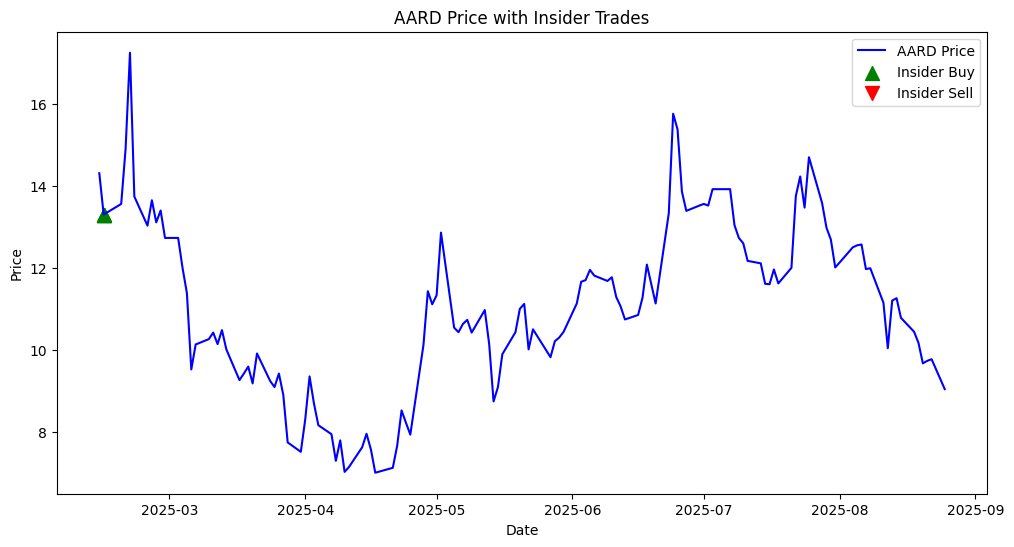

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import sys


insiders = pd.read_csv("insider_trades_with_returns.csv", parse_dates=["trade_date"], index_col="trade_date")

ticker = "AARD"
prices = get_ticker_price_history(ticker)
prices = prices.sort_index(ascending=True)

if prices.empty:
    print(f"No price data found for {ticker}")
    # Handle missing price data (e.g., skip analysis)
    sys.exit(1)

insider_trades = insiders[insiders["ticker"] == ticker]
print(f"Found {len(insider_trades)} insider trades for {ticker}")
print(insider_trades[["filing_date", "Title", "transaction_type", "purchase_price", "Value"]])

# If trade_date is not a trading day, move forward to next available trading day
for trade_date in insider_trades.index:
    if trade_date not in prices.index:
        pos = prices.index.searchsorted(trade_date)
        print(f"Trade date {trade_date.date()} not in price data, moving to next trading day {prices.index[pos].date()}")
        insider_trades = insider_trades.rename(index={trade_date: prices.index[pos]})

# Plot price history
plt.figure(figsize=(12,6))
plt.plot(prices.index, prices["Close"], label=f"{ticker} Price", color="blue")

# Plot insider purchases and sales
buys = insider_trades[insider_trades["transaction_type"]=="P - Purchase"]
sells = insider_trades[insider_trades["transaction_type"]=="S - Sale"]

plt.scatter(buys.index, 
            prices.loc[buys.index, "Close"], 
            color="green", marker="^", s=100, label="Insider Buy")

plt.scatter(sells.index, 
            prices.loc[sells.index, "Close"], 
            color="red", marker="v", s=100, label="Insider Sell")

plt.title(f"{ticker} Price with Insider Trades")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()
